In [1]:
# Cell 1: 기본 import & 경로 설정

import os
import sys
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# 프로젝트 루트 (본인 repo 경로에 맞게 수정)
PROJECT_ROOT = Path("/home/najo/NAS/VLA/Insertion_VLAv3")  # 🔴 필요시 수정
sys.path.insert(0, str(PROJECT_ROOT))

from models.unified_model import RobotStateEncoder  # MAE 학습 때와 동일한 import 경로

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [2]:
# Cell 2: MAE 모델 / Dataset / Loss 정의

from pathlib import Path

class MAERobotStateModel(nn.Module):
    """
    Masked Auto-Encoder model built around the RobotStateEncoder.
    - encoder: RobotStateEncoder
    - decoder: (model_dim → decoder_dim → 12)
    """
    def __init__(self, encoder: RobotStateEncoder, decoder_dim: int = 128):
        super().__init__()
        self.encoder = encoder
        self.encoder_dim = encoder.model_dim
        self.decoder_dim = decoder_dim
        self.output_dim = encoder.input_dim  # 보통 12 (6 joints + 6 pose)

        # Learnable mask token (1, 1, D_in) → (B, T_masked, D_in) 로 브로드캐스트
        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.output_dim))

        # 간단한 디코더 헤드
        self.decoder = nn.Sequential(
            nn.Linear(self.encoder_dim, self.decoder_dim),
            nn.GELU(),
            nn.Linear(self.decoder_dim, self.output_dim)
        )

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Args:
            src: (B, T, D_in) masked sequence
        Returns:
            reconstructed: (B, T, D_in)
        """
        encoded_sequence = self.encoder(src, return_sequence=True)  # (B, T, D_encoder)
        reconstructed_sequence = self.decoder(encoded_sequence)     # (B, T, D_in)
        return reconstructed_sequence


class RobotStateDataset(Dataset):
    """
    robot_states.npz 에서 (T, 12) sequence를 window 단위로 잘라서 제공.
    - augmentation은 평가에서는 사용하지 않음
    - 학습 때와 동일하게 전체 데이터를 이용해 mean/std 계산 후 정규화
    """
    def __init__(self, root_dir: str, window_size: int = 60, step: int = 10,
                 normalize: bool = True):
        self.window_size = window_size
        self.step = step
        self.normalize = normalize

        self.data_files = []
        print(f"[RobotStateDataset] Scanning for robot_states.npz in {root_dir}...")
        for path in Path(root_dir).rglob('robot_states.npz'):
            self.data_files.append(path)
        print(f"[RobotStateDataset] Found {len(self.data_files)} files.")

        self.windows = []
        all_data = []
        for file_path in tqdm(self.data_files, desc="Creating windows"):
            try:
                data = np.load(file_path, mmap_mode='r')['robot_states']  # (N, 12)
                if normalize:
                    all_data.append(data)

                # sliding window
                for i in range(0, len(data) - self.window_size + 1, self.step):
                    self.windows.append((file_path, i))
            except Exception as e:
                print(f"Warning: Could not load or process {file_path}: {e}")

        if normalize and len(all_data) > 0:
            all_data_concat = np.concatenate(all_data, axis=0)
            self.mean = torch.from_numpy(all_data_concat.mean(axis=0).astype(np.float32))
            self.std = torch.from_numpy(all_data_concat.std(axis=0).astype(np.float32) + 1e-6)
            print(f"📊 Normalization stats:")
            print(f"   joints mean: {self.mean[:6].numpy()}")
            print(f"   joints std : {self.std[:6].numpy()}")
            print(f"   pose   mean: {self.mean[6:].numpy()}")
            print(f"   pose   std : {self.std[6:].numpy()}")
        else:
            self.mean = None
            self.std = None

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        file_path, start_idx = self.windows[idx]
        data = np.load(file_path, mmap_mode='r')['robot_states']
        window = data[start_idx : start_idx + self.window_size]       # (T, 12)
        window_tensor = torch.from_numpy(window.astype(np.float32))   # (T, 12)

        if self.normalize and self.mean is not None and self.std is not None:
            window_tensor = (window_tensor - self.mean) / self.std

        return window_tensor  # (T, 12)


def compute_weighted_mse_loss(pred, target, mask,
                              joint_weight: float = 1.0,
                              pose_weight: float = 1.0):
    """
    학습 스크립트와 동일한 방식으로 joints / pose 분리해서 weighted MSE 계산.

    pred, target: (B, T, 12)
    mask: (B, T, 12) boolean (True = masked position)
    """
    pred_joints = pred[..., :6]
    pred_pose = pred[..., 6:]

    target_joints = target[..., :6]
    target_pose = target[..., 6:]

    mask_joints = mask[..., :6]
    mask_pose = mask[..., 6:]

    device = pred.device
    zero = torch.zeros((), device=device)

    if mask_joints.any():
        loss_joints = F.mse_loss(pred_joints[mask_joints], target_joints[mask_joints])
    else:
        loss_joints = zero

    if mask_pose.any():
        loss_pose = F.mse_loss(pred_pose[mask_pose], target_pose[mask_pose])
    else:
        loss_pose = zero

    total_loss = joint_weight * loss_joints + pose_weight * loss_pose
    return total_loss, loss_joints, loss_pose


In [4]:
# Cell 3: MAE RobotStateEncoder 로드

CKPT_PATH = PROJECT_ROOT / "checkpoints/robot_state_mae_best.pth"  # 🔴 실제 경로 확인
assert CKPT_PATH.exists(), f"Checkpoint not found: {CKPT_PATH}"

ckpt = torch.load(CKPT_PATH, map_location="cpu")

# 1) encoder_state_dict가 저장되어 있으면 그걸 우선 사용
if "encoder_state_dict" in ckpt:
    encoder_state = ckpt["encoder_state_dict"]
else:
    # 없으면 model_state_dict에서 encoder.* 만 뽑는 식으로도 가능
    encoder_state = {}
    for k, v in ckpt["model_state_dict"].items():
        if k.startswith("encoder."):
            encoder_state[k.replace("encoder.", "")] = v

# 2) pos_encoder 길이에서 window_size를 추론 (65인지 100인지 등)
pos_key_candidates = [k for k in encoder_state.keys() if "pos_encoder" in k]
if len(pos_key_candidates) == 0:
    # fallback: MAE 학습 때 사용한 window_size를 수동으로 넣어야 함
    WINDOW_SIZE = 100  # 🔴 필요시 학습 스크립트 인자에 맞게 수정
else:
    pos_key = pos_key_candidates[0]
    WINDOW_SIZE = encoder_state[pos_key].shape[1]  # (1, T_enc, D)

print(f"👉 detected window_size from checkpoint: {WINDOW_SIZE}")

# 3) MAE 학습 때 사용한 구조 (필요시 값 수정)
MODEL_DIM = 512   # --model_dim
NUM_HEADS = 8     # --num_heads
NUM_LAYERS = 4    # --num_layers
OUTPUT_DIM = 1024 # --output_dim (encoder projection head dimension)

encoder = RobotStateEncoder(
    temporal_length=WINDOW_SIZE,
    model_dim=MODEL_DIM,
    output_dim=OUTPUT_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
).to(device)

missing, unexpected = encoder.load_state_dict(encoder_state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

mae_model = MAERobotStateModel(encoder).to(device)
mae_model.eval()

print("✅ MAE RobotStateEncoder loaded on", device)


👉 detected window_size from checkpoint: 100
Missing keys: []
Unexpected keys: []
✅ MAE RobotStateEncoder loaded on cuda:0


In [10]:
# Cell: 시각화용 RobotStateDataset (단일 root)

from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset

class RobotStateDatasetForViz(Dataset):
    """
    robot_states.npz에서 (T, 12) 시퀀스를 window 단위로 제공.
    - 전체 데이터에서 mean/std를 계산해서 정규화
    - mean/std는 나중에 역정규화(denormalize)에 사용
    """
    def __init__(self, root_dir: str, window_size: int = 100, step: int = 10,
                 normalize: bool = True):
        self.window_size = window_size
        self.step = step
        self.normalize = normalize

        self.data_files = []
        print(f"[VizDataset] Scanning for robot_states.npz in {root_dir}...")
        for path in Path(root_dir).rglob('robot_states.npz'):
            self.data_files.append(path)
        print(f"[VizDataset] Found {len(self.data_files)} files.")

        self.windows = []
        all_data = []
        for file_path in self.data_files:
            try:
                data = np.load(file_path, mmap_mode='r')['robot_states']  # (N, 12)
                if normalize:
                    all_data.append(data)

                for i in range(0, len(data) - self.window_size + 1, self.step):
                    self.windows.append((file_path, i))
            except Exception as e:
                print(f"Warning: Could not load or process {file_path}: {e}")

        if normalize and len(all_data) > 0:
            all_data_concat = np.concatenate(all_data, axis=0)
            self.mean = torch.from_numpy(all_data_concat.mean(axis=0).astype(np.float32))
            self.std = torch.from_numpy(all_data_concat.std(axis=0).astype(np.float32) + 1e-6)
            print(f"📊 [VizDataset] Normalization stats:")
            print(f"   joints mean: {self.mean[:6].numpy()}")
            print(f"   joints std : {self.std[:6].numpy()}")
            print(f"   pose   mean: {self.mean[6:].numpy()}")
            print(f"   pose   std : {self.std[6:].numpy()}")
        else:
            self.mean = None
            self.std = None

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        file_path, start_idx = self.windows[idx]
        data = np.load(file_path, mmap_mode='r')['robot_states']
        window = data[start_idx : start_idx + self.window_size]      # (T, 12)
        window_tensor = torch.from_numpy(window.astype(np.float32))  # (T, 12)

        if self.normalize and self.mean is not None and self.std is not None:
            window_tensor = (window_tensor - self.mean) / self.std

        return window_tensor


In [11]:
# Cell: 시각화용 dataset 인스턴스 생성

VIZ_ROOT = "/home/najo/NAS/VLA/dataset/New_dataset2"  # 🔴 원하는 root로 수정
WINDOW_SIZE = 100  # MAE 학습할 때 썼던 window_size와 동일하게

viz_dataset = RobotStateDatasetForViz(
    root_dir=VIZ_ROOT,
    window_size=WINDOW_SIZE,
    step=10,
    normalize=True,
)

viz_mean = viz_dataset.mean.clone()
viz_std = viz_dataset.std.clone()

print(f"총 윈도우 개수(시각화용): {len(viz_dataset)}")


[VizDataset] Scanning for robot_states.npz in /home/najo/NAS/VLA/dataset/New_dataset2...
[VizDataset] Found 51 files.
📊 [VizDataset] Normalization stats:
   joints mean: [  2.2606626   0.9942941   1.7571957 -40.675106   37.461113   20.873678 ]
   joints std : [ 8.201286   6.6718426  7.845021  27.880396  20.605606  39.889847 ]
   pose   mean: [172.89508   -9.658079 266.35046  143.3978    51.14853  -20.62869 ]
   pose   std : [ 21.006918  21.53542   28.654892  26.184872  22.664831 145.55145 ]
총 윈도우 개수(시각화용): 33256


In [6]:
# Cell 5: 평가 함수 정의

def evaluate_mae_robot_encoder(
    mae_model,
    dataloader,
    device,
    mask_ratio: float = 0.5,
    max_batches: int = 200,
    joint_weight: float = 1.0,
    pose_weight: float = 1.0,
):
    mae_model.eval()

    joint_losses = []
    pose_losses = []
    total_losses = []

    D = 12
    sum_sq_error_dim = torch.zeros(D, device=device)
    count_dim = torch.zeros(D, device=device)

    sample_vis = None

    with torch.no_grad():
        for b_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating MAE")):
            if b_idx >= max_batches:
                break

            original = batch.to(device, non_blocking=True)  # (B, T, 12)
            B, T, D = original.shape

            # 1) masking (학습 스크립트와 동일 로직)
            num_masked = max(1, int(mask_ratio * T))
            rand_scores = torch.rand(B, T, device=device)
            masked_indices = rand_scores.topk(k=num_masked, dim=-1).indices  # (B, num_masked)

            masked_input = original.clone()
            loss_mask = torch.zeros_like(original, dtype=torch.bool)

            batch_indices = torch.arange(B, device=device).unsqueeze(-1)  # (B, 1)
            # (1, 1, D) → (B, num_masked, D)
            mask_tok = mae_model.mask_token.expand(B, masked_indices.shape[1], D).to(device)

            masked_input[batch_indices, masked_indices] = mask_tok
            loss_mask[batch_indices, masked_indices] = True

            # 2) reconstruction
            reconstructed = mae_model(masked_input)  # (B, T, 12)

            # 3) loss 계산 (masked 위치만)
            loss, loss_joints, loss_pose = compute_weighted_mse_loss(
                reconstructed, original, loss_mask,
                joint_weight=joint_weight,
                pose_weight=pose_weight,
            )

            total_losses.append(loss.item())
            joint_losses.append(
                loss_joints.item() if isinstance(loss_joints, torch.Tensor) else float(loss_joints)
            )
            pose_losses.append(
                loss_pose.item() if isinstance(loss_pose, torch.Tensor) else float(loss_pose)
            )

            # 4) 차원별 RMSE 통계 (masked 위치만)
            err = (reconstructed - original) ** 2  # (B, T, D)
            err_masked = err * loss_mask.float()
            sum_sq_error_dim += err_masked.sum(dim=(0, 1))
            count_dim += loss_mask.sum(dim=(0, 1))

            # 5) 시각화용 샘플 하나 저장
            if sample_vis is None:
                sample_vis = {
                    "original": original[0].detach().cpu(),      # (T, 12)
                    "recon": reconstructed[0].detach().cpu(),    # (T, 12)
                    "mask": loss_mask[0].detach().cpu(),         # (T, 12) bool
                }

    # 차원별 RMSE
    rmse_dim = torch.sqrt(sum_sq_error_dim / torch.clamp(count_dim, min=1.0))
    rmse_dim = rmse_dim.cpu().numpy()

    metrics = {
        "mean_total_loss": float(np.mean(total_losses)),
        "mean_joint_loss": float(np.mean(joint_losses)),
        "mean_pose_loss": float(np.mean(pose_losses)),
        "rmse_dim": rmse_dim,
        "count_dim": count_dim.cpu().numpy(),
        "sample": sample_vis,
    }
    return metrics


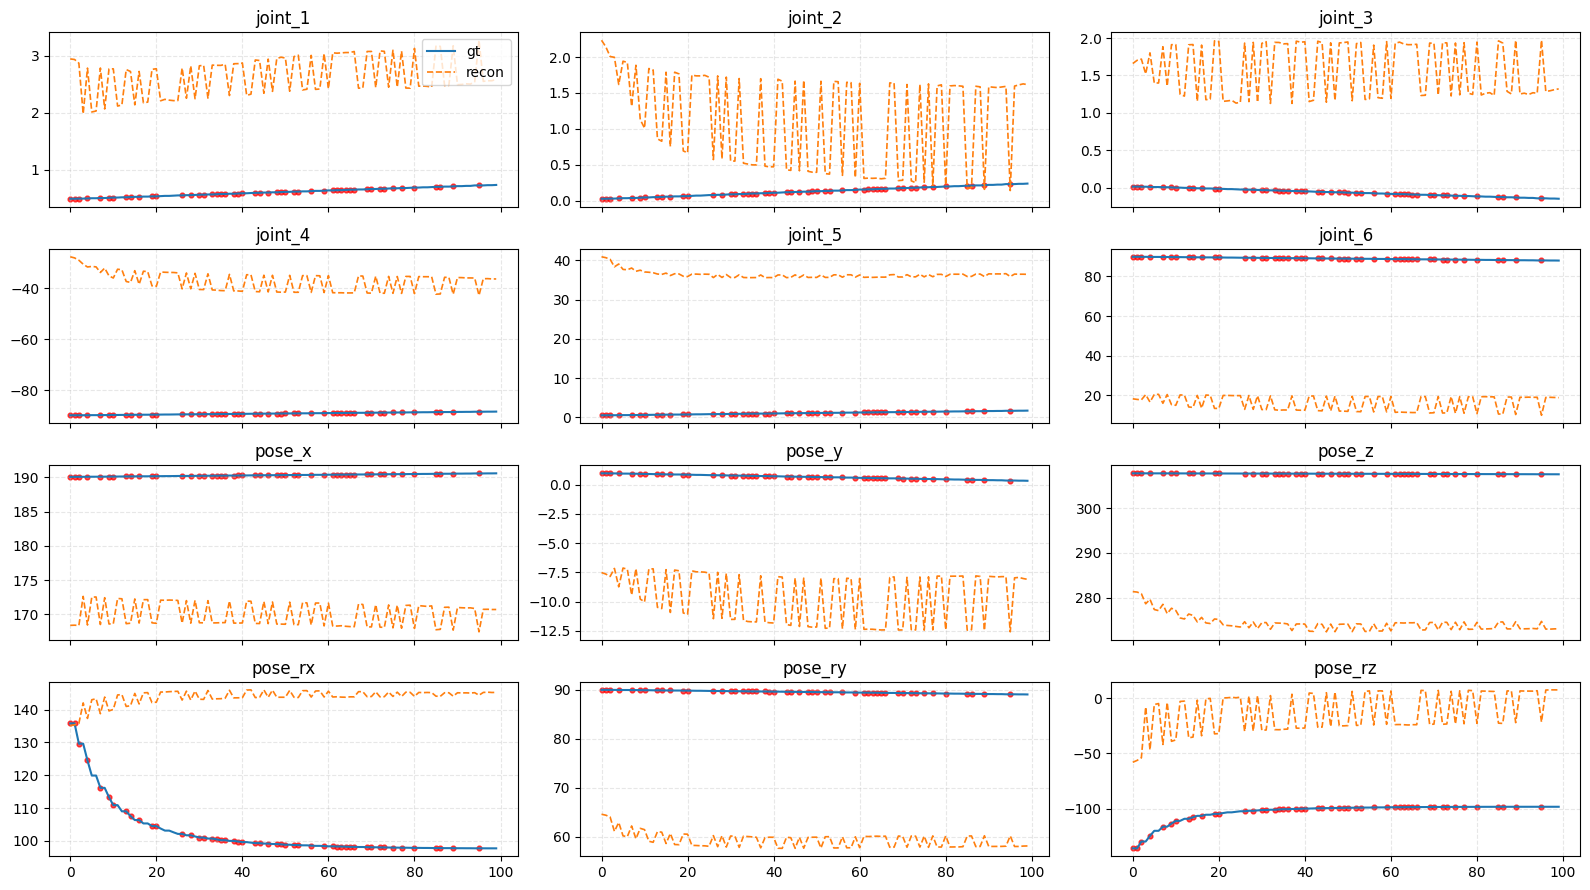

In [12]:
# Cell: 단일 시퀀스 복원 및 역정규화 후 12D 전체 시각화

import numpy as np
import matplotlib.pyplot as plt
import torch

mae_model.eval()

# 1) 시각화용 시퀀스 하나 꺼내기 (원하면 idx 바꿔도 됨)
sample_idx = 0
sample_norm = viz_dataset[sample_idx]          # (T, 12), normalized
orig_norm = sample_norm.unsqueeze(0).to(device)  # (1, T, 12)

B, T, D = orig_norm.shape
assert D == 12, f"Expected 12-dim state, got {D}"

# 2) masking (학습 스크립트 로직과 동일하게)
MASK_RATIO = 0.5
num_masked = max(1, int(MASK_RATIO * T))

rand_scores = torch.rand(B, T, device=device)
masked_indices = rand_scores.topk(k=num_masked, dim=-1).indices  # (1, num_masked)

masked_input = orig_norm.clone()
loss_mask = torch.zeros_like(orig_norm, dtype=torch.bool)

batch_indices = torch.arange(B, device=device).unsqueeze(-1)  # (1, 1)
mask_tok = mae_model.mask_token.expand(B, masked_indices.shape[1], D).to(device)

masked_input[batch_indices, masked_indices] = mask_tok
loss_mask[batch_indices, masked_indices] = True

# 3) MAE로 복원 (normalized space)
with torch.no_grad():
    recon_norm = mae_model(masked_input)  # (1, T, 12)

# 4) 정규화 해제 (denormalize) → 원래 스케일로
mean_b = viz_mean.to(device).view(1, 1, -1)  # (1,1,12)
std_b  = viz_std.to(device).view(1, 1, -1)   # (1,1,12)

orig_phys = orig_norm * std_b + mean_b      # (1, T, 12)
recon_phys = recon_norm * std_b + mean_b    # (1, T, 12)

orig_phys_np = orig_phys[0].detach().cpu().numpy()   # (T, 12)
recon_phys_np = recon_phys[0].detach().cpu().numpy() # (T, 12)
mask_t = loss_mask[0].any(dim=-1).detach().cpu().numpy()  # (T,)
t = np.arange(T)

# 5) 12차원 전체 시각화 (4 x 3 subplot)
dim_names = [
    "joint_1", "joint_2", "joint_3", "joint_4", "joint_5", "joint_6",
    "pose_x", "pose_y", "pose_z", "pose_rx", "pose_ry", "pose_rz"
]

fig, axes = plt.subplots(4, 3, figsize=(16, 9), sharex=True)
axes = axes.flatten()

for d in range(12):
    ax = axes[d]
    gt = orig_phys_np[:, d]
    pr = recon_phys_np[:, d]

    ax.plot(t, gt, label="gt", color="C0", linewidth=1.5)
    ax.plot(t, pr, label="recon", color="C1", linestyle="--", linewidth=1.2)

    # mask된 timestep에 GT 점 표시
    ax.scatter(t[mask_t], gt[mask_t], color="red", s=12, alpha=0.7)

    ax.set_title(dim_names[d])
    ax.grid(True, linestyle="--", alpha=0.3)

# legend는 첫 번째 subplot에만
axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()


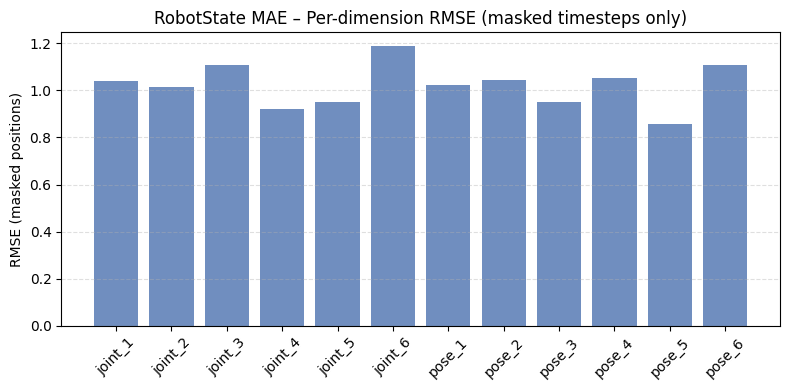

Joint dims RMSE avg: 1.0367
Pose  dims RMSE avg: 1.0044


In [8]:
# Cell 7: 차원별 RMSE 바 차트

rmse_dim = metrics["rmse_dim"]
dims = np.arange(12)

df_rmse = pd.DataFrame({
    "dim": dims,
    "name": [f"joint_{i+1}" for i in range(6)] + [f"pose_{i+1}" for i in range(6)],
    "rmse": rmse_dim,
})

plt.figure(figsize=(8, 4))
plt.bar(df_rmse["name"], df_rmse["rmse"], color="#4c72b0", alpha=0.8)
plt.xticks(rotation=45)
plt.ylabel("RMSE (masked positions)")
plt.title("RobotState MAE – Per-dimension RMSE (masked timesteps only)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# joints vs pose 평균도 간단히 확인
j_rmse = rmse_dim[:6].mean()
p_rmse = rmse_dim[6:].mean()
print(f"Joint dims RMSE avg: {j_rmse:.4f}")
print(f"Pose  dims RMSE avg: {p_rmse:.4f}")


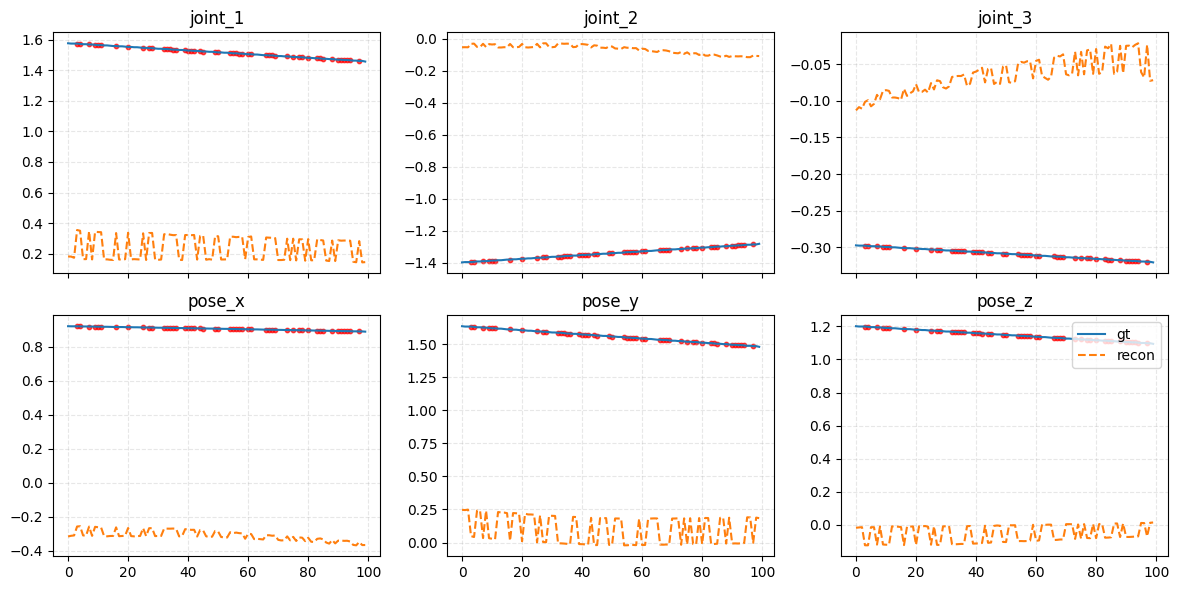

In [9]:
# Cell 8: 샘플 시퀀스 시각화 (시간축)

sample = metrics["sample"]
orig = sample["original"]   # (T, 12)
recon = sample["recon"]     # (T, 12)
mask = sample["mask"]       # (T, 12) bool

T = orig.shape[0]
t = np.arange(T)

# timestep 중 최소 하나라도 mask된 지점
mask_t = mask.any(dim=-1).numpy()  # (T,)

dims_to_plot = [0, 1, 2, 6, 7, 8]   # joint1~3, pose x/y/z 라고 가정
names = [
    "joint_1", "joint_2", "joint_3",
    "pose_x", "pose_y", "pose_z"
]

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
axes = axes.flatten()

for ax, d, name in zip(axes, dims_to_plot, names):
    gt = orig[:, d].numpy()
    pr = recon[:, d].numpy()

    ax.plot(t, gt, label="gt", color="#1f77b4")
    ax.plot(t, pr, label="recon", color="#ff7f0e", linestyle="--")

    # mask된 위치 표시 (gt 기준)
    ax.scatter(t[mask_t], gt[mask_t], color="red", s=10, alpha=0.7, label="masked(gt)" if name=="joint_1" else None)

    ax.set_title(name)
    ax.grid(True, linestyle="--", alpha=0.3)

axes[-1].legend(loc="upper right")
plt.tight_layout()
plt.show()


Device: cuda

[1] Dataset 로딩 및 정규화 통계 계산
  - 로딩: /home/najo/NAS/VLA/dataset/New_dataset3
Scanning for robot_states.npz in /home/najo/NAS/VLA/dataset/New_dataset3...
Found 50 robot_states.npz files.


Creating windows: 100%|██████████| 50/50 [00:00<00:00, 780.47it/s]

📊 Data normalization statistics computed:
   Joints mean: [ -4.2702622   6.977541   -4.5186906  -8.341138   50.832314  -17.279667 ]
   Joints std: [ 3.0191386  2.7355309  2.3887725 11.691333  13.094505  24.954107 ]
   Pose mean: [176.93538  -18.401058 248.27701  169.53973   36.383564  57.998436]
   Pose std: [  6.677058    6.2918644  20.319492   10.901401   15.614337  148.07907  ]
  -> 전체 윈도우 개수: 18566

[2] MAE 모델 생성 및 체크포인트 로드


  -> epoch: 151, best_val_loss: 0.0005663164706619019

[3] 샘플 window 가져오기 및 마스킹 / 재구성

[4] 역정규화하여 실제 스케일로 복원
  -> 전체 시퀀스 기준 per-dim MSE:
     dim 00: 0.6335
     dim 01: 1.2532
     dim 02: 0.3689
     dim 03: 22.1611
     dim 04: 41.8982
     dim 05: 91.8656
     dim 06: 3.0525
     dim 07: 6.4019
     dim 08: 82.8315
     dim 09: 16.3916
     dim 10: 44.4537
     dim 11: 1059.6598
  -> 마스킹된 위치 기준 per-dim MSE:
     dim 00: 0.0013
     dim 01: 0.0035
     dim 02: 0.0050
     dim 03: 0.7321
     dim 04: 0.6320
     dim 05: 0.9685
     dim 06: 0.0123
     dim 07: 0.1171
     dim 08: 0.8231
     dim 09: 0.3591
     dim 10: 0.5820
     dim 11: 0.2796

[5] 시각화 (GT vs Recon)


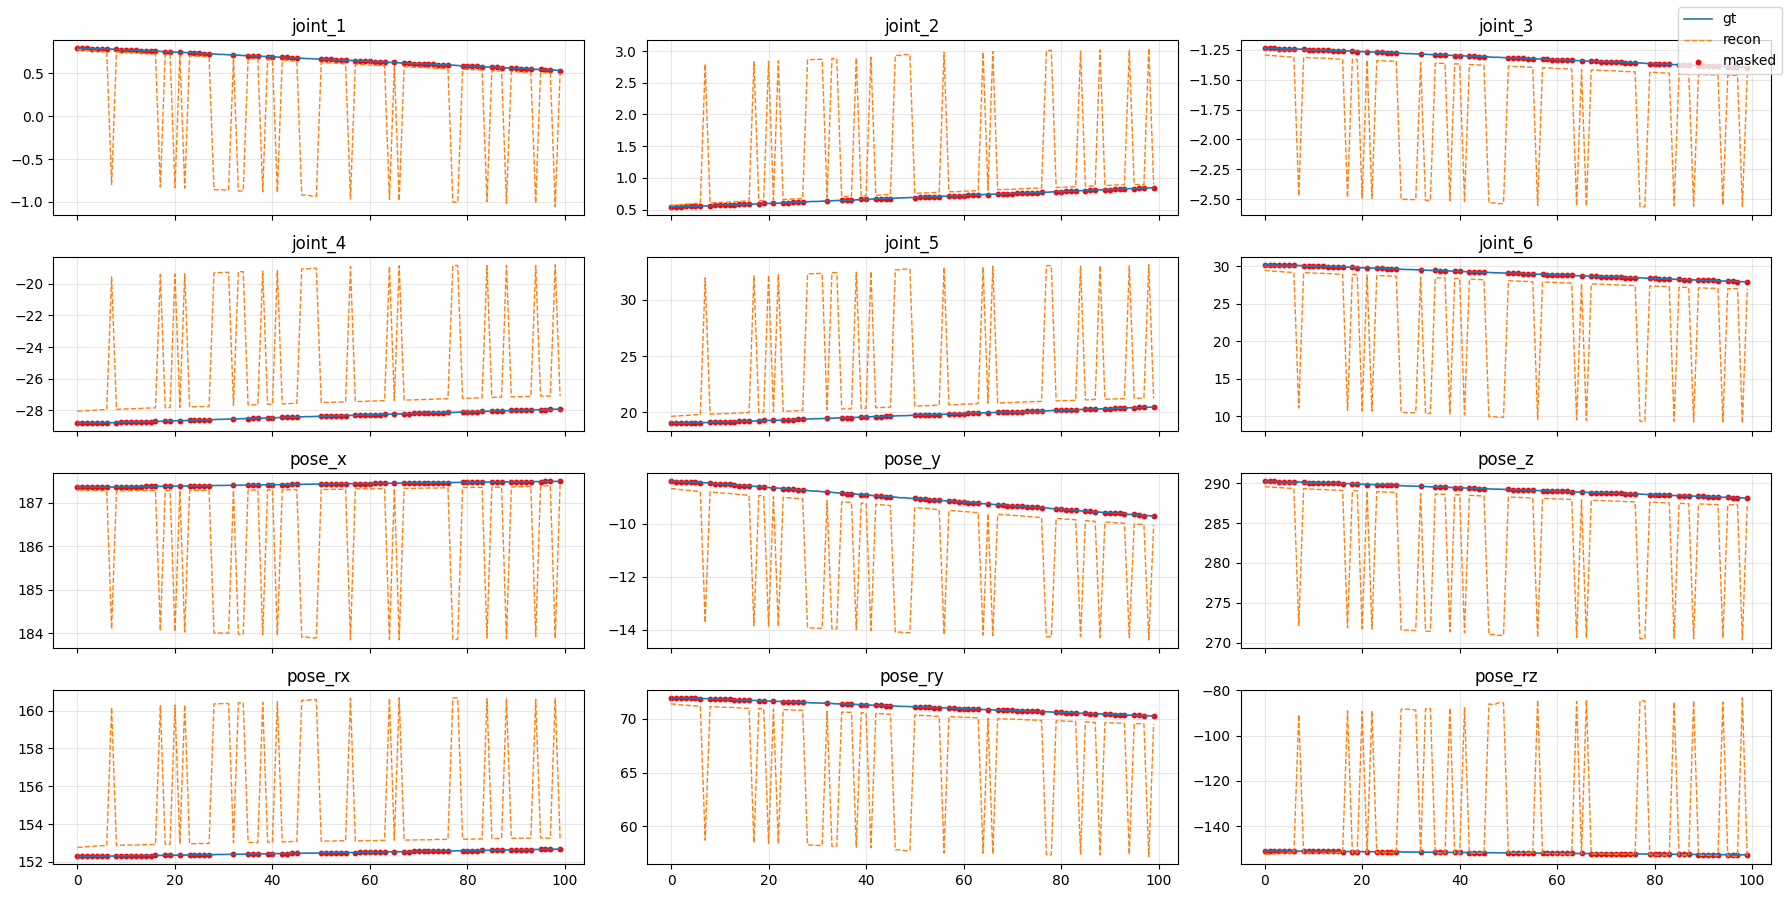


=== 테스트 완료 ===


In [29]:
# Jupyter용 Robot State MAE 재구성 테스트 & 시각화

import os
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt

# ------------------------------------------------
# 0. 환경 설정 (경로/하이퍼파라미터는 여기만 수정)
# ------------------------------------------------
checkpoint_path = "/home/najo/NAS/VLA/Insertion_VLAv3/checkpoints/robot_state_mae_latest.pth"

dataset_paths = [
    # "/home/najo/NAS/VLA/dataset/New_dataset2",
    "/home/najo/NAS/VLA/dataset/New_dataset3",
]

window_size = 100
model_dim   = 512
num_heads   = 8
num_layers  = 4
output_dim  = 1024
step        = 10       # RobotStateDataset sliding window stride (학습 때 값과 일치)
mask_ratio  = 0.75     # 학습과 동일하게 0.5
sample_index = 0       # 보고 싶은 window index

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------
# 1. 필요한 모듈 import (학습 코드에서 썼던 것 그대로)
#    파일명은 실제 학습 스크립트 이름에 맞게 변경
# ------------------------------------------------
# 예: mae 학습 스크립트가 robot_state_mae_train.py 라고 가정
from TRAIN_RobotState_MAE import MAERobotStateModel, RobotStateDataset

# models.unified_model 위치가 프로젝트 루트 기준이라고 가정
import sys
PROJECT_ROOT = Path(".").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from models.unified_model import RobotStateEncoder


# ------------------------------------------------
# 2. ConcatDataset에서 mean/std까지 같이 꺼내는 헬퍼
# ------------------------------------------------
def get_sample_with_stats(dataset, idx):
    """
    dataset: RobotStateDataset 또는 ConcatDataset
    반환: (window_norm_tensor, mean_tensor, std_tensor)
    - window_norm_tensor: (T, 12)  이미 (x - mean) / std 된 값
    - mean/std: (12,)
    """
    if isinstance(dataset, ConcatDataset):
        cumulative_sizes = dataset.cumulative_sizes
        ds_idx = 0
        while idx >= cumulative_sizes[ds_idx]:
            ds_idx += 1
        if ds_idx == 0:
            sample_idx = idx
        else:
            sample_idx = idx - cumulative_sizes[ds_idx - 1]
        ds = dataset.datasets[ds_idx]
        window = ds[sample_idx]
        mean = ds.mean
        std = ds.std
        return window, mean, std
    else:
        ds = dataset
        window = ds[idx]
        mean = ds.mean
        std = ds.std
        return window, mean, std


# ------------------------------------------------
# 3. Dataset 구성 (정규화 포함, augmentation은 OFF)
# ------------------------------------------------
print("\n[1] Dataset 로딩 및 정규화 통계 계산")

datasets = []
for root_dir in dataset_paths:
    root_dir = Path(root_dir)
    print(f"  - 로딩: {root_dir}")
    ds = RobotStateDataset(
        root_dir=str(root_dir),
        window_size=window_size,
        step=step,
        use_augmentation=False,  # 테스트에서는 augmentation 끔
        normalize=True,
    )
    ds.eval()
    datasets.append(ds)

if len(datasets) == 1:
    dataset = datasets[0]
else:
    dataset = ConcatDataset(datasets)

total_windows = len(dataset)
print(f"  -> 전체 윈도우 개수: {total_windows}")
if sample_index >= total_windows:
    raise ValueError(f"sample_index {sample_index} 가 전체 길이 {total_windows} 보다 큼")


# ------------------------------------------------
# 4. MAE 모델 생성 + 체크포인트 로드
# ------------------------------------------------
print("\n[2] MAE 모델 생성 및 체크포인트 로드")

encoder = RobotStateEncoder(
    temporal_length=window_size,
    model_dim=model_dim,
    output_dim=output_dim,
    num_heads=num_heads,
    num_layers=num_layers,
)
mae_model = MAERobotStateModel(encoder=encoder).to(device)

ckpt = torch.load(checkpoint_path, map_location=device)
mae_model.load_state_dict(ckpt["model_state_dict"], strict=True)
mae_model.eval()

print(f"  -> epoch: {ckpt.get('epoch', 'unknown')}, best_val_loss: {ckpt.get('best_val_loss', 'N/A')}")


# ------------------------------------------------
# 5. 한 샘플 뽑아서 마스킹 후 재구성
# ------------------------------------------------
print("\n[3] 샘플 window 가져오기 및 마스킹 / 재구성")

window_norm, mean, std = get_sample_with_stats(dataset, sample_index)
window_norm = window_norm.unsqueeze(0).to(device)        # (1, T, 12)
mean = mean.to(device).view(1, 1, -1)                   # (1, 1, 12)
std = std.to(device).view(1, 1, -1)                     # (1, 1, 12)

B, T, D = window_norm.shape
assert D == 12, f"Expected 12 dims, got {D}"

# timestep 기준 마스킹 (학습과 동일)
num_masked = max(1, int(mask_ratio * T))
masked_indices = torch.rand(B, T, device=device).topk(k=num_masked, dim=-1).indices  # (B, num_masked)

masked_input = window_norm.clone()
loss_mask = torch.zeros_like(masked_input, dtype=torch.bool)

batch_indices = torch.arange(B, device=device).unsqueeze(-1)  # (B, 1)
mask_tok = mae_model.mask_token.expand(B, masked_indices.shape[1], D)

masked_input[batch_indices, masked_indices] = mask_tok
loss_mask[batch_indices, masked_indices] = True

with torch.no_grad():
    recon_norm = mae_model(masked_input)  # (1, T, 12)


# ------------------------------------------------
# 6. 역정규화해서 실제 스케일로 복원
# ------------------------------------------------
print("\n[4] 역정규화하여 실제 스케일로 복원")

orig_phys = window_norm * std + mean    # (1, T, 12)
recon_phys = recon_norm * std + mean    # (1, T, 12)

orig_np = orig_phys.squeeze(0).cpu().numpy()   # (T, 12)
recon_np = recon_phys.squeeze(0).cpu().numpy() # (T, 12)
mask_np = loss_mask.squeeze(0).cpu().numpy()   # (T, 12) bool

sq_err = (orig_np - recon_np) ** 2
mse_total = sq_err.mean(axis=0)
mse_masked = (sq_err * mask_np).sum(axis=0) / np.maximum(mask_np.sum(axis=0), 1)

print("  -> 전체 시퀀스 기준 per-dim MSE:")
for i, m in enumerate(mse_total):
    print(f"     dim {i:02d}: {m:.4f}")

print("  -> 마스킹된 위치 기준 per-dim MSE:")
for i, m in enumerate(mse_masked):
    print(f"     dim {i:02d}: {m:.4f}")


# ------------------------------------------------
# 7. 시각화 (GT vs Recon, 마스킹된 위치 표시)
# ------------------------------------------------
print("\n[5] 시각화 (GT vs Recon)")

dim_names = [
    "joint_1", "joint_2", "joint_3", "joint_4", "joint_5", "joint_6",
    "pose_x", "pose_y", "pose_z", "pose_rx", "pose_ry", "pose_rz",
]
t_axis = np.arange(orig_np.shape[0])

fig, axes = plt.subplots(4, 3, figsize=(18, 9), sharex=True)
axes = axes.ravel()

for d in range(orig_np.shape[1]):
    ax = axes[d]
    ax.plot(t_axis, orig_np[:, d], label="gt", color="C0", linewidth=1.2)
    ax.plot(t_axis, recon_np[:, d], label="recon", color="C1", linestyle="--", linewidth=1.0)

    # 마스킹된 위치는 빨간 점으로 표시
    masked_t = np.where(mask_np[:, d])[0]
    if len(masked_t) > 0:
        ax.scatter(masked_t, orig_np[masked_t, d], color="red", s=10, label="masked" if d == 0 else None)

    ax.set_title(dim_names[d])
    ax.grid(alpha=0.3)

# 남은 subplot이 있으면 비활성화
for k in range(orig_np.shape[1], len(axes)):
    axes[k].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()

print("\n=== 테스트 완료 ===")



[5] 시각화 (GT vs Recon, masked에 초점)


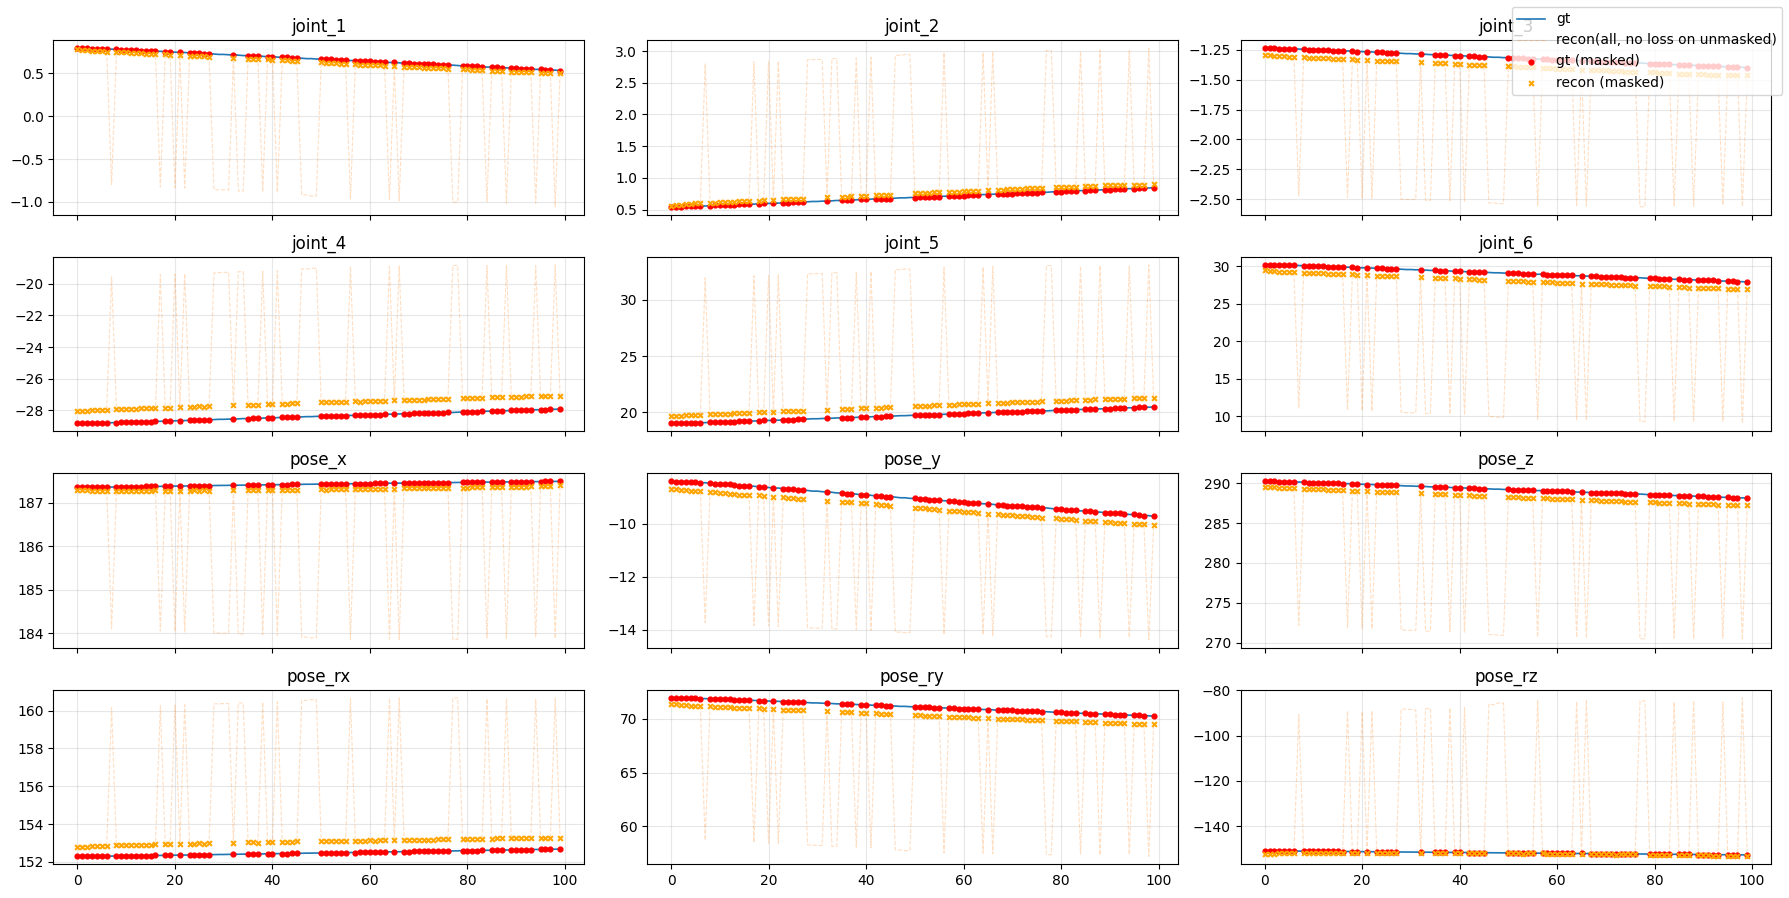

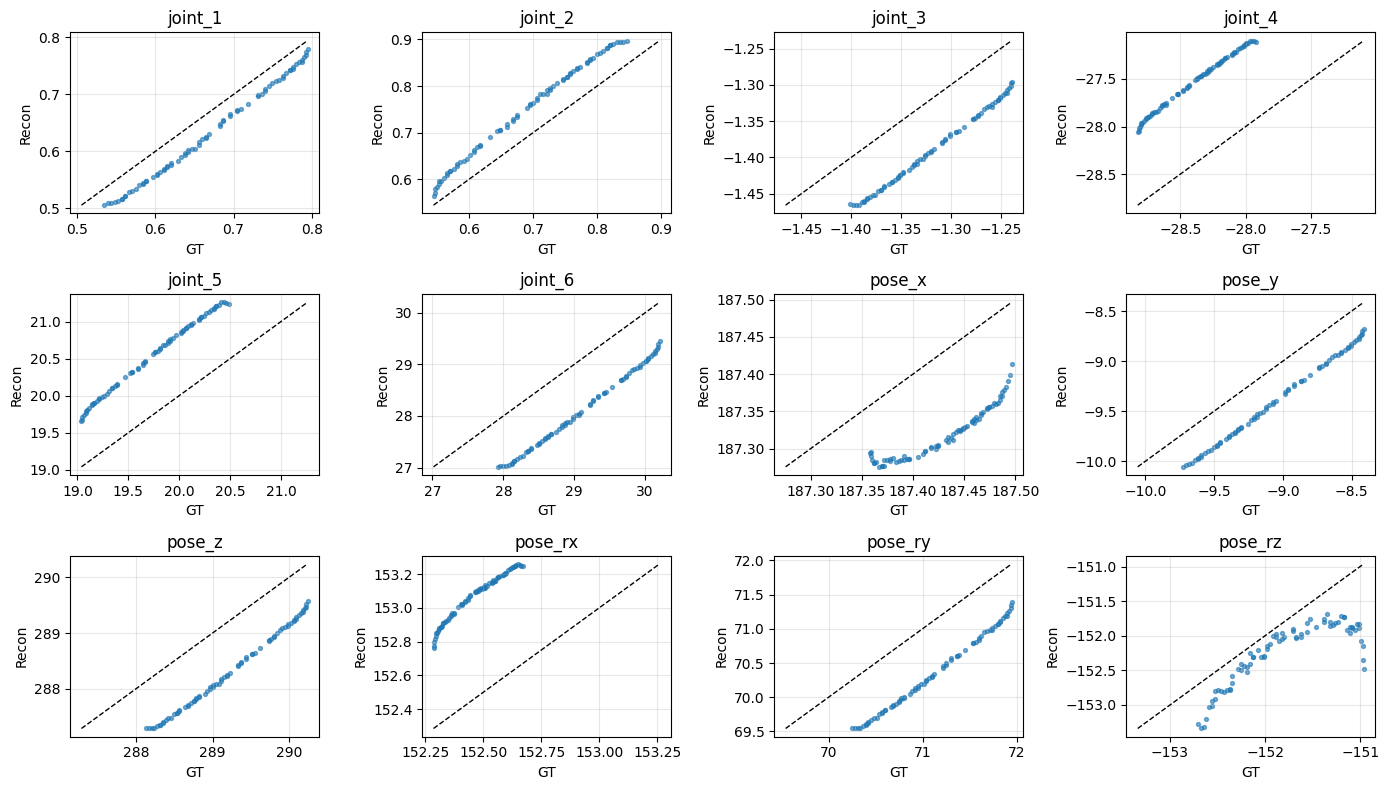

In [32]:
# ------------------------------------------------
# 5. 시각화 (GT vs Recon) - MAE 목적에 맞게 수정
# ------------------------------------------------
print("\n[5] 시각화 (GT vs Recon, masked에 초점)")

dim_names = [
    "joint_1", "joint_2", "joint_3", "joint_4", "joint_5", "joint_6",
    "pose_x", "pose_y", "pose_z", "pose_rx", "pose_ry", "pose_rz",
]
t_axis = np.arange(orig_np.shape[0])

fig, axes = plt.subplots(4, 3, figsize=(18, 9), sharex=True)
axes = axes.ravel()

for d in range(orig_np.shape[1]):
    ax = axes[d]

    # 1) GT 전체 시퀀스
    ax.plot(t_axis, orig_np[:, d], label="gt", color="C0", linewidth=1.2)

    # 2) recon 전체는 "loss 안 걸린 구간"이므로 연하게만(참고용)
    ax.plot(
        t_axis, recon_np[:, d],
        label="recon(all, no loss on unmasked)",
        color="C1", linestyle="--", linewidth=0.8, alpha=0.25
    )

    # 3) 마스크된 위치에서의 recon만 강조
    masked_t = np.where(mask_np[:, d])[0]
    if len(masked_t) > 0:
        ax.scatter(
            masked_t, orig_np[masked_t, d],
            color="red", s=12, label="gt (masked)" if d == 0 else None, zorder=3
        )
        ax.scatter(
            masked_t, recon_np[masked_t, d],
            color="orange", s=12, marker="x",
            label="recon (masked)" if d == 0 else None, zorder=3
        )

    ax.set_title(dim_names[d])
    ax.grid(alpha=0.3)

# 남은 subplot이 있으면 비활성화
for k in range(orig_np.shape[1], len(axes)):
    axes[k].axis("off")

handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
# 중복 제거
uniq = dict(zip(labels, handles))
fig.legend(uniq.values(), uniq.keys(), loc="upper right")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 6. (선택) masked 위치에 대한 GT vs Recon 산점도
# ------------------------------------------------
fig2, axes2 = plt.subplots(3, 4, figsize=(14, 8))
axes2 = axes2.ravel()

for d in range(orig_np.shape[1]):
    ax = axes2[d]
    gt_m   = orig_np[mask_np[:, d], d]
    pred_m = recon_np[mask_np[:, d], d]

    if len(gt_m) == 0:
        ax.set_title(dim_names[d] + " (no masked)")
        ax.axis("off")
        continue

    ax.scatter(gt_m, pred_m, s=8, alpha=0.6)
    vmin = min(gt_m.min(), pred_m.min())
    vmax = max(gt_m.max(), pred_m.max())
    ax.plot([vmin, vmax], [vmin, vmax], 'k--', linewidth=1)  # y=x 기준선
    ax.set_title(dim_names[d])
    ax.set_xlabel("GT")
    ax.set_ylabel("Recon")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [41]:
# ------------------------------------------------
# 4.x RMSE 계산 (전체 시퀀스 / masked 위치 기준)
# ------------------------------------------------
sq_err = (orig_np - recon_np) ** 2          # (T, 12)
mse_total  = sq_err.mean(axis=0)           # (12,)
rmse_total = np.sqrt(mse_total)

# masked 위치만 사용
masked_count = mask_np.sum(axis=0)         # (12,)
mse_masked = np.sum(sq_err * mask_np, axis=0) / np.maximum(masked_count, 1)
rmse_masked = np.sqrt(mse_masked)

print("\n[4.x] RMSE (전체 시퀀스 기준, per-dim):")
for i, r in enumerate(rmse_total):
    print(f"  dim {i:02d} ({dim_names[i]}): {r:.4f}")

print("\n[4.x] RMSE (masked 위치 기준, per-dim):")
for i, r in enumerate(rmse_masked):
    # masked가 전혀 없으면 값이 의미 없으니 표시만 따로
    if masked_count[i] == 0:
        print(f"  dim {i:02d} ({dim_names[i]}): N/A (no masked)")
    else:
        print(f"  dim {i:02d} ({dim_names[i]}): {r:.4f}")



[4.x] RMSE (전체 시퀀스 기준, per-dim):
  dim 00 (joint_1): 0.7959
  dim 01 (joint_2): 1.1195
  dim 02 (joint_3): 0.6073
  dim 03 (joint_4): 4.7076
  dim 04 (joint_5): 6.4729
  dim 05 (joint_6): 9.5847
  dim 06 (pose_x): 1.7471
  dim 07 (pose_y): 2.5302
  dim 08 (pose_z): 9.1012
  dim 09 (pose_rx): 4.0487
  dim 10 (pose_ry): 6.6674
  dim 11 (pose_rz): 32.5524

[4.x] RMSE (masked 위치 기준, per-dim):
  dim 00 (joint_1): 0.0365
  dim 01 (joint_2): 0.0593
  dim 02 (joint_3): 0.0706
  dim 03 (joint_4): 0.8556
  dim 04 (joint_5): 0.7950
  dim 05 (joint_6): 0.9841
  dim 06 (pose_x): 0.1107
  dim 07 (pose_y): 0.3422
  dim 08 (pose_z): 0.9072
  dim 09 (pose_rx): 0.5993
  dim 10 (pose_ry): 0.7629
  dim 11 (pose_rz): 0.5288



[5] 시각화 (GT vs Recon, masked only, tick step = 1.0)


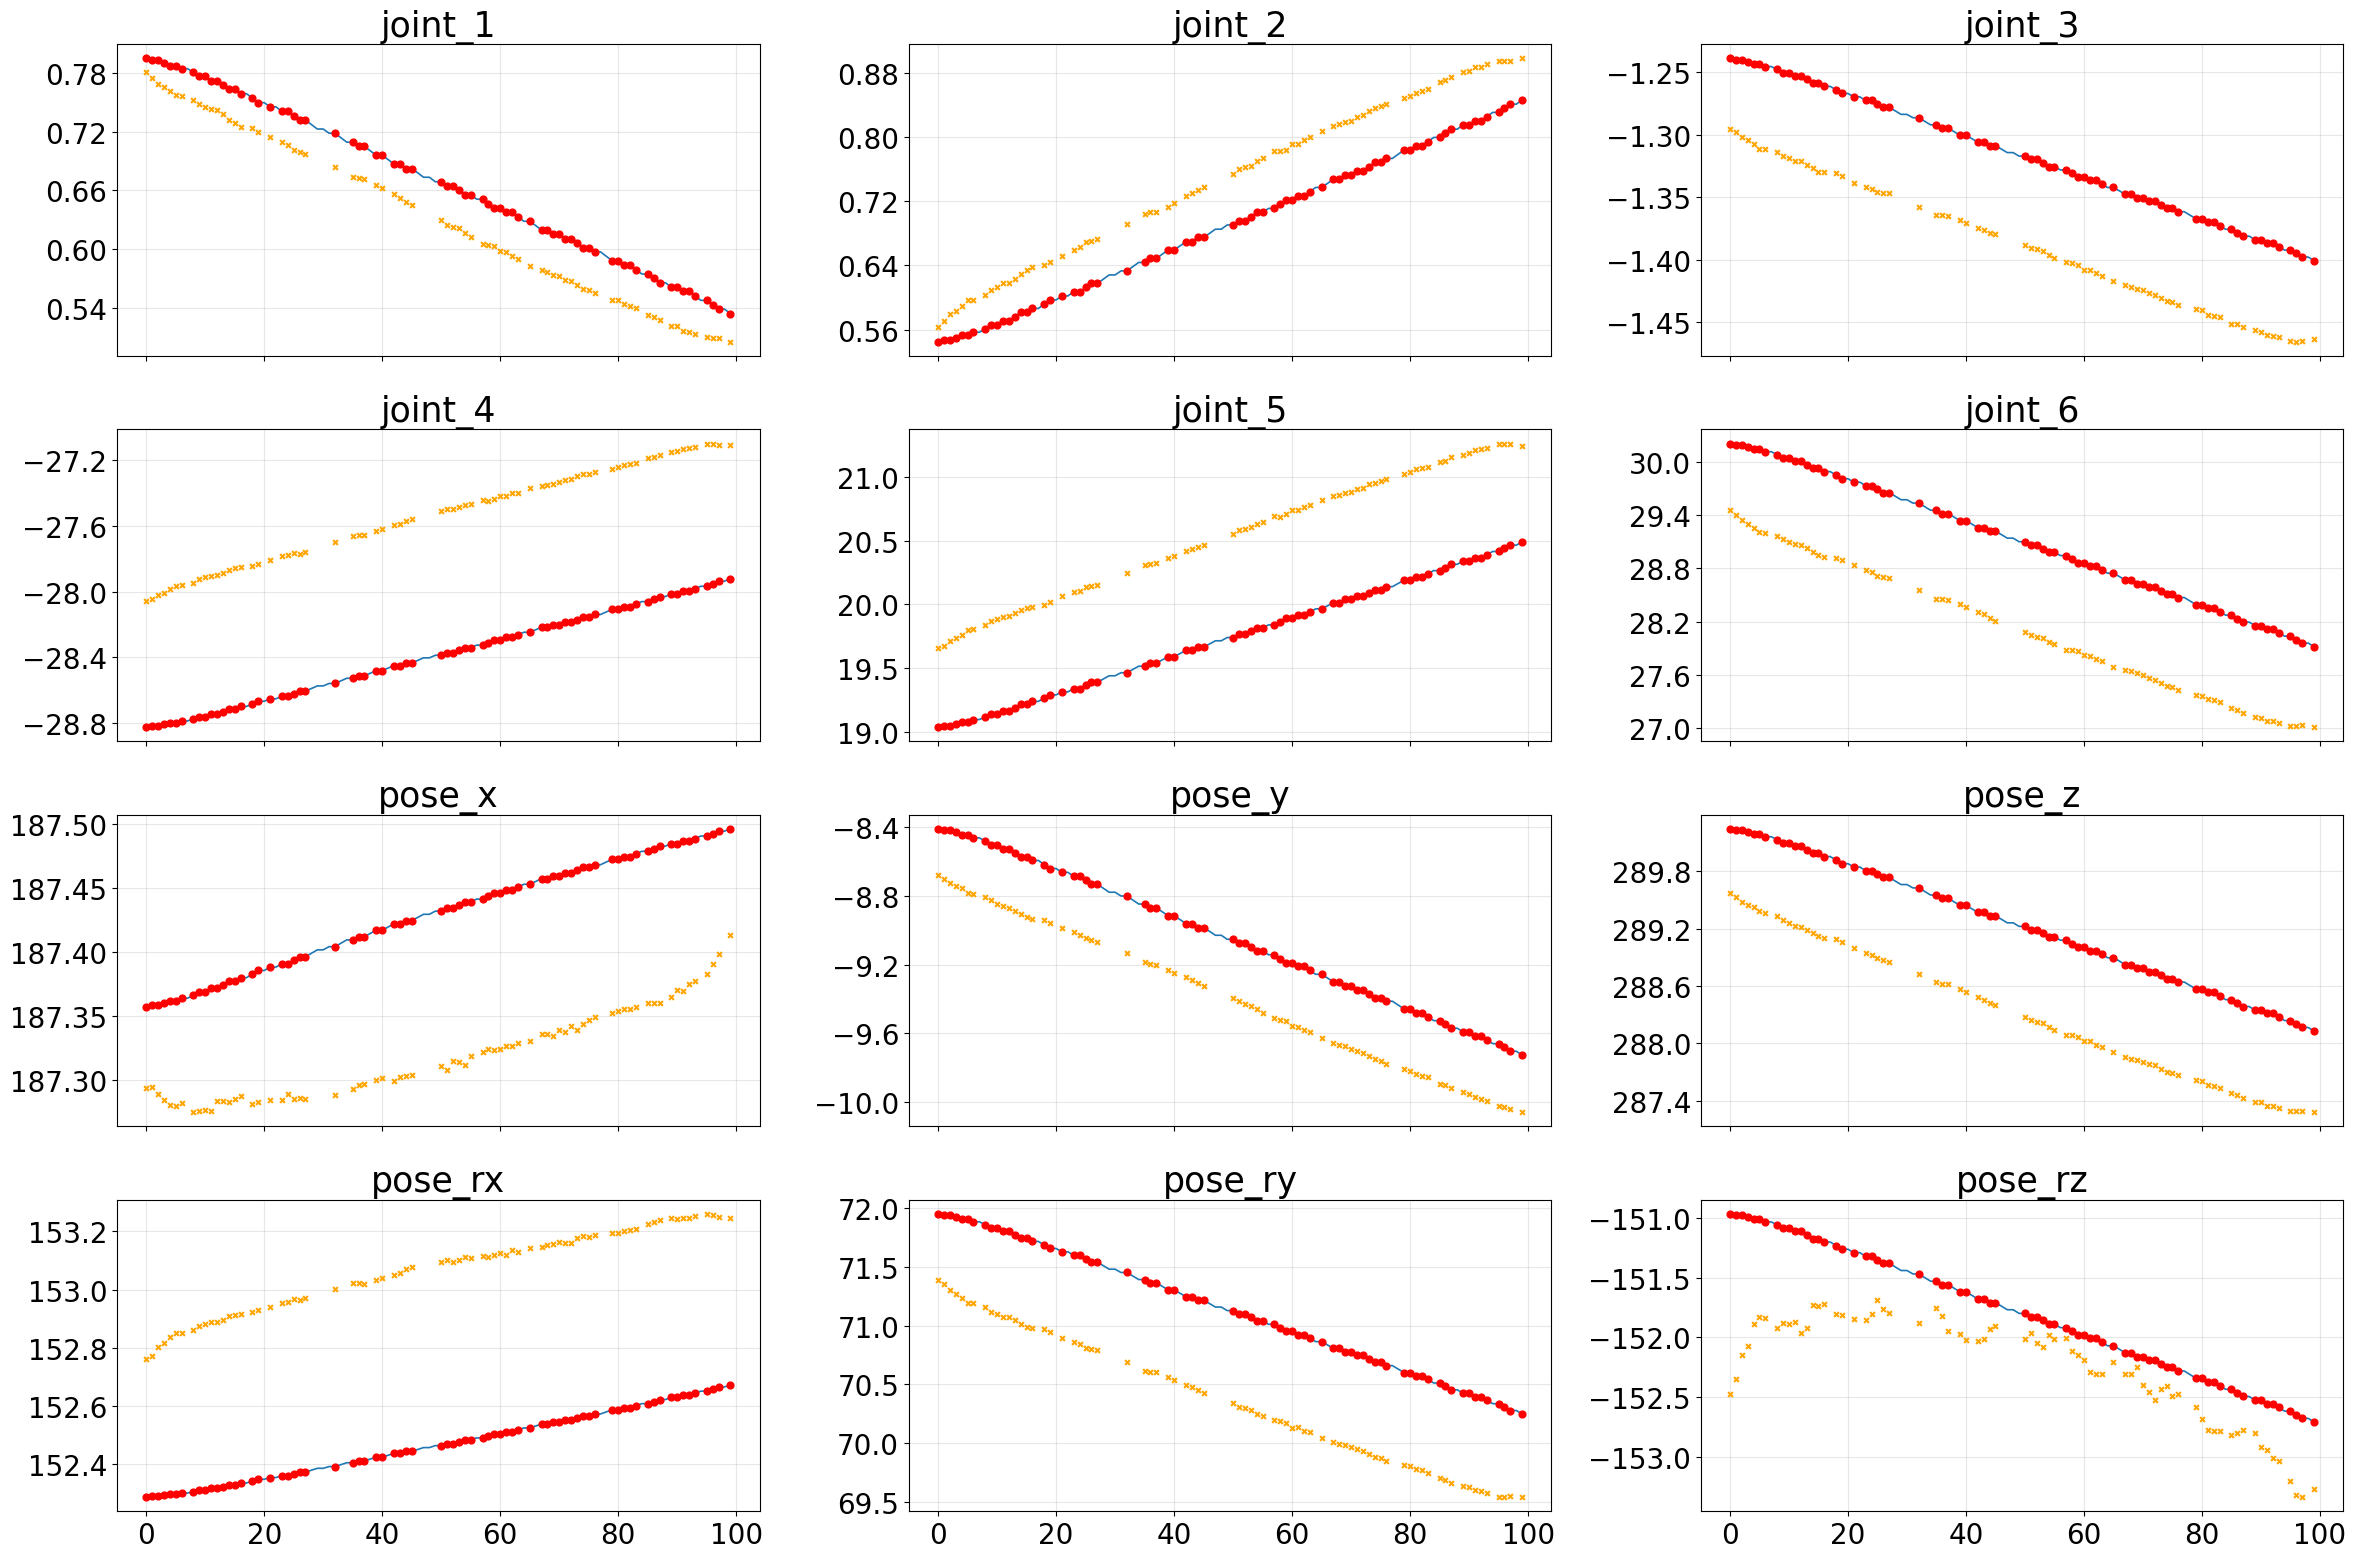

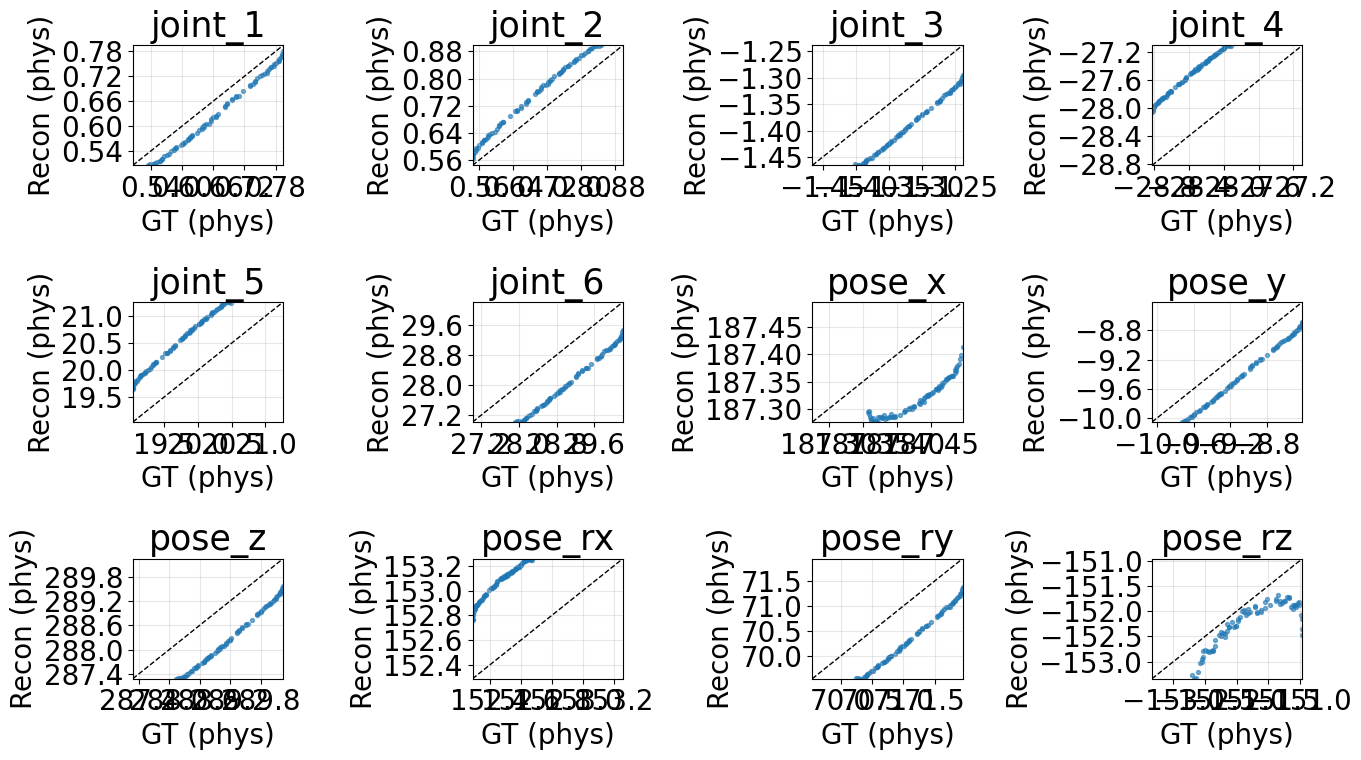

In [54]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator

# 전역 폰트 설정
plt.rcParams.update({
    "font.size": 20,        # 기본 글씨
    "axes.titlesize": 25,   # axes title
    "axes.labelsize": 20,   # x, y label
    "xtick.labelsize": 20,  # x tick
    "ytick.labelsize": 20,  # y tick
    "legend.fontsize": 14,  # legend
})


# ------------------------------------------------
# 5. 시각화 (GT vs Recon, masked only, 모든 값 물리 스케일 + tick 간격 1)
# ------------------------------------------------
print("\n[5] 시각화 (GT vs Recon, masked only, tick step = 1.0)")

dim_names = [
    "joint_1", "joint_2", "joint_3", "joint_4", "joint_5", "joint_6",
    "pose_x", "pose_y", "pose_z", "pose_rx", "pose_ry", "pose_rz",
]
t_axis = np.arange(orig_np.shape[0])  # (T,)

fig, axes = plt.subplots(4, 3, figsize=(24, 16), sharex=True)
axes = axes.ravel()

for d in range(orig_np.shape[1]):
    ax = axes[d]

    gt_series    = orig_np[:, d]    # 물리 스케일 GT
    recon_series = recon_np[:, d]   # 물리 스케일 Recon

    # 1) GT 전체 시퀀스
    ax.plot(t_axis, gt_series, label="gt", color="C0", linewidth=1.2)

    # 2) 마스킹된 위치에서의 GT / Recon만 표시
    masked_t = np.where(mask_np[:, d])[0]
    if len(masked_t) > 0:
        # masked 구간의 GT
        ax.scatter(
            masked_t, gt_series[masked_t],
            color="red", s=24,
            label="gt (masked)" if d == 0 else None,
            zorder=3,
        )
        # masked 구간의 Recon
        ax.scatter(
            masked_t, recon_series[masked_t],
            color="orange", s=12, marker="x",
            label="recon (masked)" if d == 0 else None,
            zorder=3,
        )

    ax.set_title(dim_names[d])
    ax.grid(alpha=0.3)
    # ★ y축 눈금 간격 1.0으로 고정 (joint, pose 모두)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6, prune="both"))

# 남은 subplot 비활성화
for k in range(orig_np.shape[1], len(axes)):
    axes[k].axis("off")

# 범례 정리 (중복 제거)
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
uniq = dict(zip(labels, handles))
# fig.legend(uniq.values(), uniq.keys(), loc="upper right")

plt.tight_layout()
plt.show()

# ------------------------------------------------
# 6. masked 위치에 대한 GT vs Recon 산점도 (물리 값 + tick 간격 1)
# ------------------------------------------------
fig2, axes2 = plt.subplots(3, 4, figsize=(14, 8))
axes2 = axes2.ravel()

for d in range(orig_np.shape[1]):
    ax = axes2[d]

    gt_m   = orig_np[mask_np[:, d], d]     # 물리 GT (masked 위치만)
    pred_m = recon_np[mask_np[:, d], d]    # 물리 Recon (masked 위치만)

    if len(gt_m) == 0:
        ax.set_title(dim_names[d] + " (no masked)")
        ax.axis("off")
        continue

    vmin = min(gt_m.min(), pred_m.min())
    vmax = max(gt_m.max(), pred_m.max())

    ax.scatter(gt_m, pred_m, s=8, alpha=0.6)
    ax.plot([vmin, vmax], [vmin, vmax], 'k--', linewidth=1)  # y=x 기준선

    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.set_title(dim_names[d])
    ax.set_xlabel("GT (phys)")
    ax.set_ylabel("Recon (phys)")
    ax.grid(alpha=0.3)

    # ★ x, y축 눈금 간격 1.0
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune="both"))

plt.tight_layout()
plt.show()
